### Purpose
This notebook will be used to demonstrate the changes of the surge and sway forces ($F_{x}$ and $F_{y}$) as the angle of encounter ($\beta$) and number of frequencies change.

In [69]:
import numpy as np
import control
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
def sig_waveheight(V_knots, g):
    
    V = V_knots * 0.5144    # Conversion from knots to m/s
    H_s = 0.21 * (V**2 / g)
    
    return H_s

def energy_density(omega, A_sp, B_sp):
    x = -B_sp / omega**4
    S = (A_sp / omega**5) * np.exp(x)
    
    return S

def Amp(S, delta_omega):
    A = 2 * S * delta_omega
    A = np.sqrt(A)
    
    return A

def wave_slope(A_i, omega_i, g, t, phi_i):
    wave = A_i * (omega_i**2 / g) * np.sin(omega_i * t + phi_i)
    
    return wave

In [71]:
#     Declaration of variables
V_knots = 30    # In knots
g = 9.81        # Gravity
t = np.linspace(0,60,6001)

#     Range of frequencies per Energy Density Spectrum
start_omega = 0.2 
end_omega = 1.2
delta_omega = end_omega - start_omega

#     Range of phase angles
start_phi = 0.
end_phi = 2*np.pi

#     Creation of blank arrays
S_array = []
wave_array = []
total_wave = []
all_waves = []

In [72]:
for i in range(3,8,2):
    N = i
    counter = 0
    while counter < N:
        omega = np.linspace(start_omega, end_omega, N)
        phi = np.linspace(start_phi, end_phi, N)
        
        #     Calculates Significant Wave Height, A_sp, and B_sp values
        H_s = sig_waveheight(V_knots,g)
        A_sp = 8.1 * 10**-3 * g**2
        B_sp = 3.11 / H_s**2
        
        #     Pulls values of omega and phi from array according to counter
        omega_i = omega[counter]
        phi_i = phi[counter]

        #     Calculates energy density of wave per current omega value and stores in array
        S = energy_density(omega_i, A_sp, B_sp)
        if np.size(S_array) == 0:
            S_array = S
        else:
            S_array = np.vstack((S_array, S))

        #     Calculates A_i value that will be used in wave calculation
        A_i = Amp(S, delta_omega)

        #     Calculates total wave for current omega
        wave = wave_slope(A_i, omega_i, g, t, phi_i)

        #     Stores calculated wave in wave_array
        if np.size(wave_array) == 0:
            wave_array = wave
        else:
            wave_array = np.vstack((wave_array, wave))
            
        #     Sum individual waves to create total wave slope of wave with N-frequencies
        if np.size(total_wave) == 0:
            total_wave = wave_array
        else:
            total_wave = total_wave + wave_array[counter,:]
            
        counter = counter + 1
            
    
    if np.size(all_waves) == 0:
        all_waves = total_wave
    else:
        all_waves = np.vstack((all_waves, total_wave))

####Code above is copied from "PMS Multi Frequency Wave Plots.ipynb". The following code will calculate the surge force using the wave slopes found above.

In [73]:
rho = 1027.     # Density in kg/m^3
B_S = 2.5        # Width of ship in meters
L_S = 4.        # Length of ship in meters
T_S = .75       # Depth of flotation in meters

total_F_x = []
total_F_y = []
total_M_z = []

rho_bar = rho * g * B_S * L_S

#   Angle in which wave encounters vessel
beta_deg = 0
beta = np.radians(beta_deg)


F_x_3 = rho_bar * T_S * np.cos(beta) * all_waves[0,:]
F_x_5 = rho_bar * T_S * np.cos(beta) * all_waves[1,:]
F_x_7 = rho_bar * T_S * np.cos(beta) * all_waves[2,:]


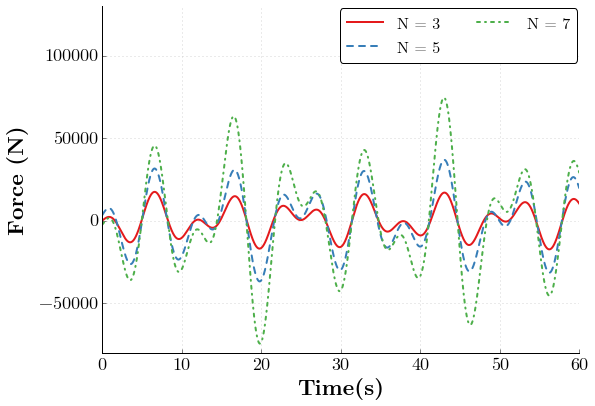

In [74]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Time(s)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'Force (N)',family='Serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(t, F_x_3, linewidth=2, linestyle = '-',   label=r'N = 3')
plt.plot(t, F_x_5, linewidth=2, linestyle = '--',   label=r'N = 5')
plt.plot(t, F_x_7, linewidth=2, linestyle = '-.',   label=r'N = 7')

# plt.xlim(0,1.6)
plt.ylim(-80000,130000)

leg = plt.legend(loc='upper right', fancybox=True, ncol=2)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
plt.savefig('multi_frequency_forces_{}kn_{}deg.pdf'.format(V_knots, beta_deg))

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook
plt.show()